In [1]:
# Общие библиотеки
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

# Для создания и обучения модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchsummary import summary

# Для работы с изображениями
import cv2
from PIL import Image

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!rm -rf /content/drive/MyDrive/sputnik/train/train

In [ ]:
!unzip "/content/drive/MyDrive/test_dataset_test.zip" -d "/content/drive/MyDrive/sputnik/test"

## Аугументация


In [ ]:
import imageio
import imgaug.augmenters as iaa
from imgaug import augmenters as iaa

In [5]:
file_source = '/content/drive/MyDrive/sputnik/train/img/'
get_files = os.listdir(file_source)
# for i in get_files:
#   print(int(i.split('.')[0]))
for j in range(3): 
  for i in tqdm(range(800)):
    # i = int(i.split('.')[0])
    image_name, labels = data_df.iloc[i]['id'], [data_df.iloc[i]['left_top_x'], 
                                                                data_df.iloc[i]['left_top_y'], 
                                                                data_df.iloc[i]['right_top_x'], 
                                                                data_df.iloc[i]['right_top_y'],
                                                                data_df.iloc[i]['left_bottom_x'], 
                                                                data_df.iloc[i]['left_bottom_y'],  
                                                                data_df.iloc[i]['right_bottom_x'], 
                                                                data_df.iloc[i]['right_bottom_y'], 
                                                                data_df.iloc[i]['angle']]

    
    # читаем картинку. read the image
    image = cv2.imread(f"/content/drive/MyDrive/sputnik/train/img/{image_name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augimg = seq.augment(image=image)
    # plt.imshow(image)

    data = {}
    data['left_top'] = []
    data['right_top'] = []
    data['left_bottom'] = []
    data['right_bottom'] = [] 
    data['angle'] = []  

    data['left_top'] = ([labels[0],labels[1]])
    data['right_top'] = ([labels[2],labels[3]])
    data['left_bottom'] = ([labels[4],labels[5]])
    data['right_bottom'] = ([labels[6],labels[7]]) 
    data['angle'] = (labels[8])  

    sub_dir = f"/content/json{j}/"
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)
    with open(f'/content/json{j}/out_{j}_{i}.json', 'w') as outfile:
      json.dump(data, outfile)
      
    sub_dir1 = f"/content/img{j}/"
    if not os.path.exists(sub_dir1):
        os.makedirs(sub_dir1)
    unique, counts = np.unique(augimg, return_counts=True)
    if len(counts) > 0 and counts[0]/counts.sum() < .1:
      cv2.imwrite(f'/content/img{j}/out_{j}_{i}.png', augimg)

## Тренировочный Датасет


In [6]:
json_dir = "/content/drive/MyDrive/sputnik/train/json/"

data_df = pd.DataFrame({'id': [],
                        'center_x' : [],
                        'center_y' : [],
                        'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      if 'data' in x:
        #   continue
        #   if int(x.split("_")[3][:-5]) > 180:
        #     continue
          new_row = {'id':f'out_{x.split("_")[1]}_{x.split("_")[2]}_{x.split("_")[3][:-5]}.png',
                     'center_x' : (data["left_top"][0] + data["right_top"][0] + data["left_bottom"][0] + data["right_bottom"][0])/4,
                     'center_y' : (data["left_top"][1] + data["right_top"][1] + data["left_bottom"][1] + data["right_bottom"][1])/4,
                     'angle': data["angle"]}
      else:
         new_row = {'id':x.split(".")[0]+".png",
                    'center_x' : (data["left_top"][0] + data["right_top"][0] + data["left_bottom"][0] + data["right_bottom"][0])/4,
                    'center_y' : (data["left_top"][1] + data["right_top"][1] + data["left_bottom"][1] + data["right_bottom"][1])/4,
                    'angle': data["angle"]}
                    
      data_df = data_df.append(new_row, ignore_index=True)


In [13]:
data_df.head(5)

,id,center_x,center_y,angle
0,1.png,9183.5,2501.5,341.0
1,100.png,7337.5,4113.5,246.0
2,1000.png,6190.5,9573.5,53.0
3,1003.png,5844.5,7282.5,215.0
4,1004.png,5499.5,9360.5,356.0


In [86]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['center_x']/10496, 
                                                            self.data_df.iloc[idx]['center_y']/10496, 
                                                            self.data_df.iloc[idx]['angle']/360]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/sputnik/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [87]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [ ]:
# читаем датасет
# data_df = pd.read_csv("/content/train.csv")

In [16]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/drive/MyDrive/sputnik/train/img/")))
print("Тестовой выборки " ,len(listdir("/content/drive/MyDrive/sputnik/test/")))

Обучающей выборки  800
Тестовой выборки  400


In [88]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.1)#, random_state=333)

In [59]:
train_df.shape, valid_df.shape

((720, 4), (80, 4))

In [89]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [72]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Вспомогательные функции

In [90]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array(data_true[0]).astype(int)
    y_center_true = np.array(data_true[1]).astype(int)

    x_metr = x_center_true - np.array(data_pred[0]).astype(int)
    y_metr = y_center_true - np.array(data_pred[1]).astype(int)

    metr =  1 - (0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[2] - data_true[2])/360)
    return metr

In [91]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [92]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    

    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :2] = y_pred[:, :2] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :2] = labels[:, :2] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                pred[:, :2] = pred[:, :2] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :2] = labels[:, :2] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модели

In [24]:
torch.cuda.empty_cache()

## ResNet

In [ ]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
lin = model.fc
new_lin = nn.Sequential(
    nn.Linear(lin.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 3),
)

model.fc = new_lin

model.load_state_dict(torch.load('/content/drive/MyDrive/sputnik/resnet/weights.pth'))
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

## EfficentNet

In [ ]:
!pip install efficientnet_pytorch

In [93]:
from efficientnet_pytorch import EfficientNet

In [99]:
model_2 = EfficientNet.from_pretrained('efficientnet-b4')
last = model_2._fc
model_2._fc = nn.Linear(last.in_features, 3)
# model_2.load_state_dict(torch.load('/content/drive/MyDrive/sputnik/model/weights.pth'))

Loaded pretrained weights for efficientnet-b4


In [ ]:
model_2

In [100]:
model_2 = model_2.cuda()

In [101]:
criterion = torch.nn.MSELoss()

In [103]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [104]:
torch.cuda.empty_cache()

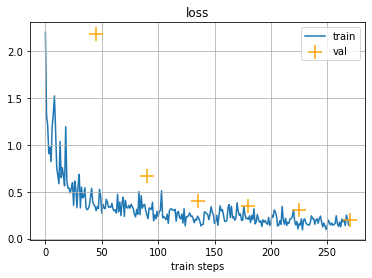

 40%|████      | 6/15 [04:23<06:36, 44.09s/it]

Train loss: 0.1735794412282606
Val loss: 0.19932544557377693
Train metric: 0.8750646958706502
Val metric: 0.8686087375181477


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_2, 
                                                                 criterion, 
                                                                 optimizer_2, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 15)

In [69]:
torch.save(model_2, '/content/drive/MyDrive/sputnik/effnet/weights.pth')

## Посчитаем метрику

In [ ]:
total_metric = []

for imgs, labels in valid_loader:
    imgs = imgs.cuda()
    labels = labels.cpu().detach().numpy()            
    pred = model_2(imgs)
    pred = pred.cpu().detach().numpy()    

    pred[:, :2] = pred[:, :2] * 10496
    pred[:, -1] = pred[:, -1] * 360

    labels[:, :2] = labels[:, :2] * 10496
    labels[:, -1] = labels[:, -1] * 360
    
    for label, pr in zip(labels, pred):
        total_metric.append(compute_metric(label, pr))
    
total_metric = np.mean(total_metric)
print('Valid metric:', total_metric)

# Создадим предсказания на тестовом наборе данных

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/sputnik/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.files)

In [ ]:
test_images_dir = '/content/drive/MyDrive/sputnik/test/'

for _, _, test_files in os.walk(test_images_dir):
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

In [ ]:
indexes = [x.split('.')[0] for x in test_files]
preds = []

for imgs in test_loader:
    imgs = imgs.cuda()            
    pred = model_2(imgs)
    pred = pred.cpu().detach().numpy()
    pred[:, :2] = np.clip(pred[:, :2] * 10496, 0, 10496)
    pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
    preds.extend(list(pred))

In [ ]:
sub_dir = "/content/submission/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[0], pred[1]]
    left_bottom = [pred[0], pred[1]]
    right_bottom = [pred[0], pred[1]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[2]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)

In [ ]:
!zip -r /content/submission.zip /content/submission

updating: content/submission/ (stored 0%)
updating: content/submission/870.json (deflated 53%)
updating: content/submission/31.json (deflated 53%)
updating: content/submission/501.json (deflated 53%)
updating: content/submission/798.json (deflated 53%)
updating: content/submission/1049.json (deflated 53%)
updating: content/submission/923.json (deflated 53%)
updating: content/submission/960.json (deflated 54%)
updating: content/submission/1047.json (deflated 53%)
updating: content/submission/836.json (deflated 53%)
updating: content/submission/578.json (deflated 53%)
updating: content/submission/633.json (deflated 53%)
updating: content/submission/888.json (deflated 53%)
updating: content/submission/748.json (deflated 53%)
updating: content/submission/643.json (deflated 54%)
updating: content/submission/495.json (deflated 53%)
updating: content/submission/349.json (deflated 53%)
updating: content/submission/1132.json (deflated 53%)
updating: content/submission/162.json (deflated 53%)
up